In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
from sklearn.decomposition import PCA
import tabulate
import itertools
import igraph as ig
import matplotlib.patches as mpatches
from sklearn.neighbors import radius_neighbors_graph
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
import leidenalg as la
import dask.array as da
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import umap
import bbknn
import bbknn.matrix
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget
import sys

# locals
sys.path.append("../")
import utils as ut
reload(ut)

2023-03-07 09:05:34.809468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 09:05:34.919584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-03-07 09:05:34.919607: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 09:05:34.945716: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 09:05:36.4768

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/clustering/../utils.py'>

In [2]:
np.random.seed(0)

In [3]:
# load cluster assignments
cdf = pd.read_csv("../clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


In [4]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


In [5]:
keys = ['ND', 'HFD8', 'HFD14']
ctypes = ['Macrophages', 'Monocytes']
ctypes = ['Macrophages']

res = []
refs = []

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    
    for ctype in ctypes:
        cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
        mask = clusterIds.isin(cellTypeIds)
        
        # extract cells
        cells = df[mask]
        print(cells.shape)
        
        # extract cell ids
        r = pd.DataFrame(cells.index)
        r.columns = ['CellId']
        r['key'] = key
        r['ctype'] = ctype
        
        res.append(cells)
        refs.append(r)

        
res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
refs = pd.concat(refs, ignore_index=True)
print(f"{refs.shape=}")

print(refs['ctype'].value_counts(normalize=True))
print()
res.head()

(359, 12490)
(2188, 13768)
(3884, 13479)
res.shape=(6431, 14205)
refs.shape=(6431, 3)
Macrophages    1.0
Name: ctype, dtype: float64



MRPL15    LYPLA1     TCEA1   ATP6V1H    RB1CC1  4732440D04RIK  PCMTD1  \
0  0.000000  0.000000  1.540236  0.000000  1.540236            0.0     0.0   
1  0.000000  0.000000  0.000000  0.000000  1.167320            0.0     0.0   
2  0.751568  0.000000  0.000000  0.751568  0.000000            0.0     0.0   
3  0.000000  0.000000  0.000000  0.000000  0.619184            0.0     0.0   
4  0.000000  1.463523  1.463523  0.000000  0.000000            0.0     0.0   

   RRS1  MYBL1  VCPIP1  ...  KATNAL2  SIGLEC15  BBS1  PELI3  CST6  GM10353  \
0   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
1   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
2   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
3   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
4   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   

   SCGB1A1  MS4A2  LIPN  SLIT1  
0      NaN    NaN   NaN    NaN  
1      NaN    NaN   NaN    NaN  
2      NaN    NaN   NaN    NaN  
3      NaN    NaN   NaN    NaN  
4      NaN    NaN   NaN    NaN  

[5 rows x 14205 columns]

Removed 5900 Genes with STD < 0.2
Retained: 8305
Xpca.shape=(6431, 40)
distances.shape=(6431, 6431)
connectivies.shape=(6431, 6431)


Text(0.5, 1.0, 'Macrophages')

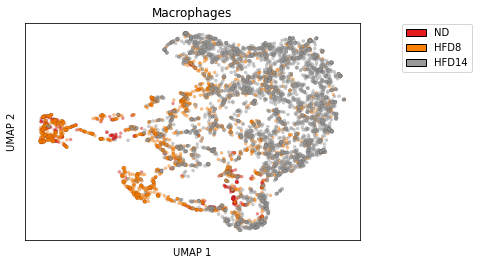

In [6]:
"""create a low-dimensional embedding for visualization """
X = res.fillna(0)
totalG = X.shape[1]

# remove low variance genes
stdT = 0.2
geneStd = X.std(axis=0)
mask = geneStd < stdT
X = X[X.columns[~mask]]
g = X.shape[1]
print(f"Removed {totalG - g} Genes with STD < {stdT}")
print(f"Retained: {g}")


"""
BBKNN
"""
r = 40
pca = PCA(n_components=r)
pcaModel = pca.fit(X)
Xpca = pca.fit_transform(X)
print(f"{Xpca.shape=}")

distances, connectivies, parameters = bbknn.matrix.bbknn(Xpca, refs['key'].to_list())

print(f"{distances.shape=}")
print(f"{connectivies.shape=}")


# plotting params
n_components = 2 # should always be 2
n_neighbors = 6
min_dist = 0.05
metric= "euclidean"

umap_reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         metric=metric)

embedding = umap_reducer.fit_transform(connectivies) # we need embedding by cell
embedding = pd.DataFrame(embedding)
embedding.columns = ['x', 'y']


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

"""add color information """

colorBy = 'key'
cmap = 'Set1'

colors = ut.ncolor(refs[colorBy].nunique(), cmap=cmap)
colors = dict(zip(refs[colorBy].unique(), colors))

handles = []

for label, color in colors.items():
    handle = mpatches.Patch(color=color, 
                            ec='k', 
                            label=f"{label}")
    
    handles.append(handle)
    
refs[f'color'] = refs[colorBy].map(colors)

plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=40,
            edgecolor='k',
            lw=0.1,
            c=refs[f'color'].to_list(),
            alpha=0.5)

plt.legend(handles=handles, bbox_to_anchor=(1.35, 1.02))
_ = plt.xticks([])
_ = plt.yticks([])

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f"{ctype}")

In [7]:
# break

In [8]:
# """Estimate the rank of the data matrix: WARNING takes a long time """
# # remove low variance genes
# stdT = 0.2
# X = res.fillna(0)
# geneStd = X.std(axis=0)
# mask = geneStd < stdT
# X = X[X.columns[~mask]]
# X = X.to_numpy()
# print(f"{X.shape=}")

# # _ = plt.hist(geneStd, 
# #              bins=30,
# #              color="lightgrey", 
# #              edgecolor="k")

# # plt.xlabel(r"Expression Variability ($\sigma$)")
# # plt.ylabel("Number of Genes")
# # plt.show()

# u, s, vh = np.linalg.svd(X)
# print(f"{u.shape=}, {s.shape=}, {vh.shape=}")

# def getOHT(u, s, vh):
#     m = u.shape[0]
#     n = vh.shape[0] 
#     beta = m / n
#     omega = (0.56*beta**3) - (0.95 * beta**2) + (1.82 * beta) + 1.43
#     y_med = np.median(s)
#     tau = omega * y_med
#     s_ind = np.argwhere(s >= tau)
#     oht = np.max(s_ind) 
#     return oht, tau

# oht, tau = getOHT(u, s, vh)
# print(f"{oht=} {tau=}")

# sNorm = s.copy()
# sNorm /= np.max(sNorm)

# xp = [x/s.sum() for x in s]
# cumXp = np.cumsum(xp)
# over80 = np.min(np.argwhere(cumXp > 0.8))
# print(f"{over80=}")

# # smooth
# smooth = gaussian_filter1d(sNorm, 3)

# # compute second derivative
# smooth_d2 = np.gradient(np.gradient(smooth))
# infl = np.min(np.where(np.diff(np.sign(smooth_d2)))[0]) - 1 
# print(f"{infl=}")

# eigengap = np.argmax(np.abs(np.diff(s[:30]))) + 2
# print(f"{eigengap=}")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 4, 2

# plt.plot(range(len(s)), 
#          s, 
#          lw=1, 
#          c="k")

# plt.yscale("log")
# plt.ylabel("Magnitude")
# plt.xlabel("Singular Value")

# plt.scatter(eigengap,
#             s[eigengap],
#             marker=".",
#             c='b', 
#             ec='k',
#             lw=1,
#             s=90,
#             label=f"eigengap={eigengap}")


# plt.scatter(oht,
#             s[oht+1],
#             marker=".",
#             c='red', 
#             ec='k',
#             lw=1,
#             s=90,
#             label=f"OHT={oht+1}")

# # plt.scatter(over80,
# #             s[over80+1],
# #             marker=".",
# #             c='green', 
# #             ec='k',
# #             lw=1,
# #             s=90,
# #             label=f"80%={over80+1}")

# # plt.scatter(infl,
# #             s[infl],
# #             marker=".",
# #             c='green', 
# #             ec='k',
# #             lw=1,
# #             s=90,
# #             label=f"min f''(s)={infl}")

# plt.legend()
# plt.title(f"X dim {X.shape}, sigmaT={stdT}")

In [9]:
# t = 20
# plt.plot(range(len(s[:t])), 
#          s[:t], 
#          lw=1,
#          marker=".",
#          c="k")

# plt.ylabel("Magnitude")
# plt.xlabel(f"First {t} Singular Values")

In [10]:
# break

In [11]:
def getDistanceMatrix(X, r=15, metric='euclidean', returnExp=False):
    """A function to compute pairwise distances from scRNA data """    
    # compute the PCA 
    pca = PCA(n_components=r)
    pcaModel = pca.fit(X)
    Xpca = pca.fit_transform(X)
    
    # compute pairwise similarity
    A = metrics.pairwise_distances(Xpca, metric=metric)
    
    if returnExp:
        exVar = pcaModel.explained_variance_
        xp = [x/exVar.sum() for x in exVar]
        cumXp = np.cumsum(xp)
        
        return A, cumXp
    else:
        return A

In [12]:
# t = 0.8
# rRange = np.linspace(5, 100, 50).astype(int)

# result = []

# for r in rRange:
#     A, ex = getDistanceMatrix(res.fillna(0), r=r)
#     huer = np.min(np.argwhere(ex >= t)) + 1 
    
#     row = {
#         "nPCA" : r,
#         "First" : ex[0],
#         f"Hueristic" : huer
#     }
#     result.append(row)
    
# result = pd.DataFrame(result)
# result.head()

# plt.scatter(result['nPCA'], 
#             result['Hueristic'])

X.shape=(6431, 8305)
(6431, 6431)


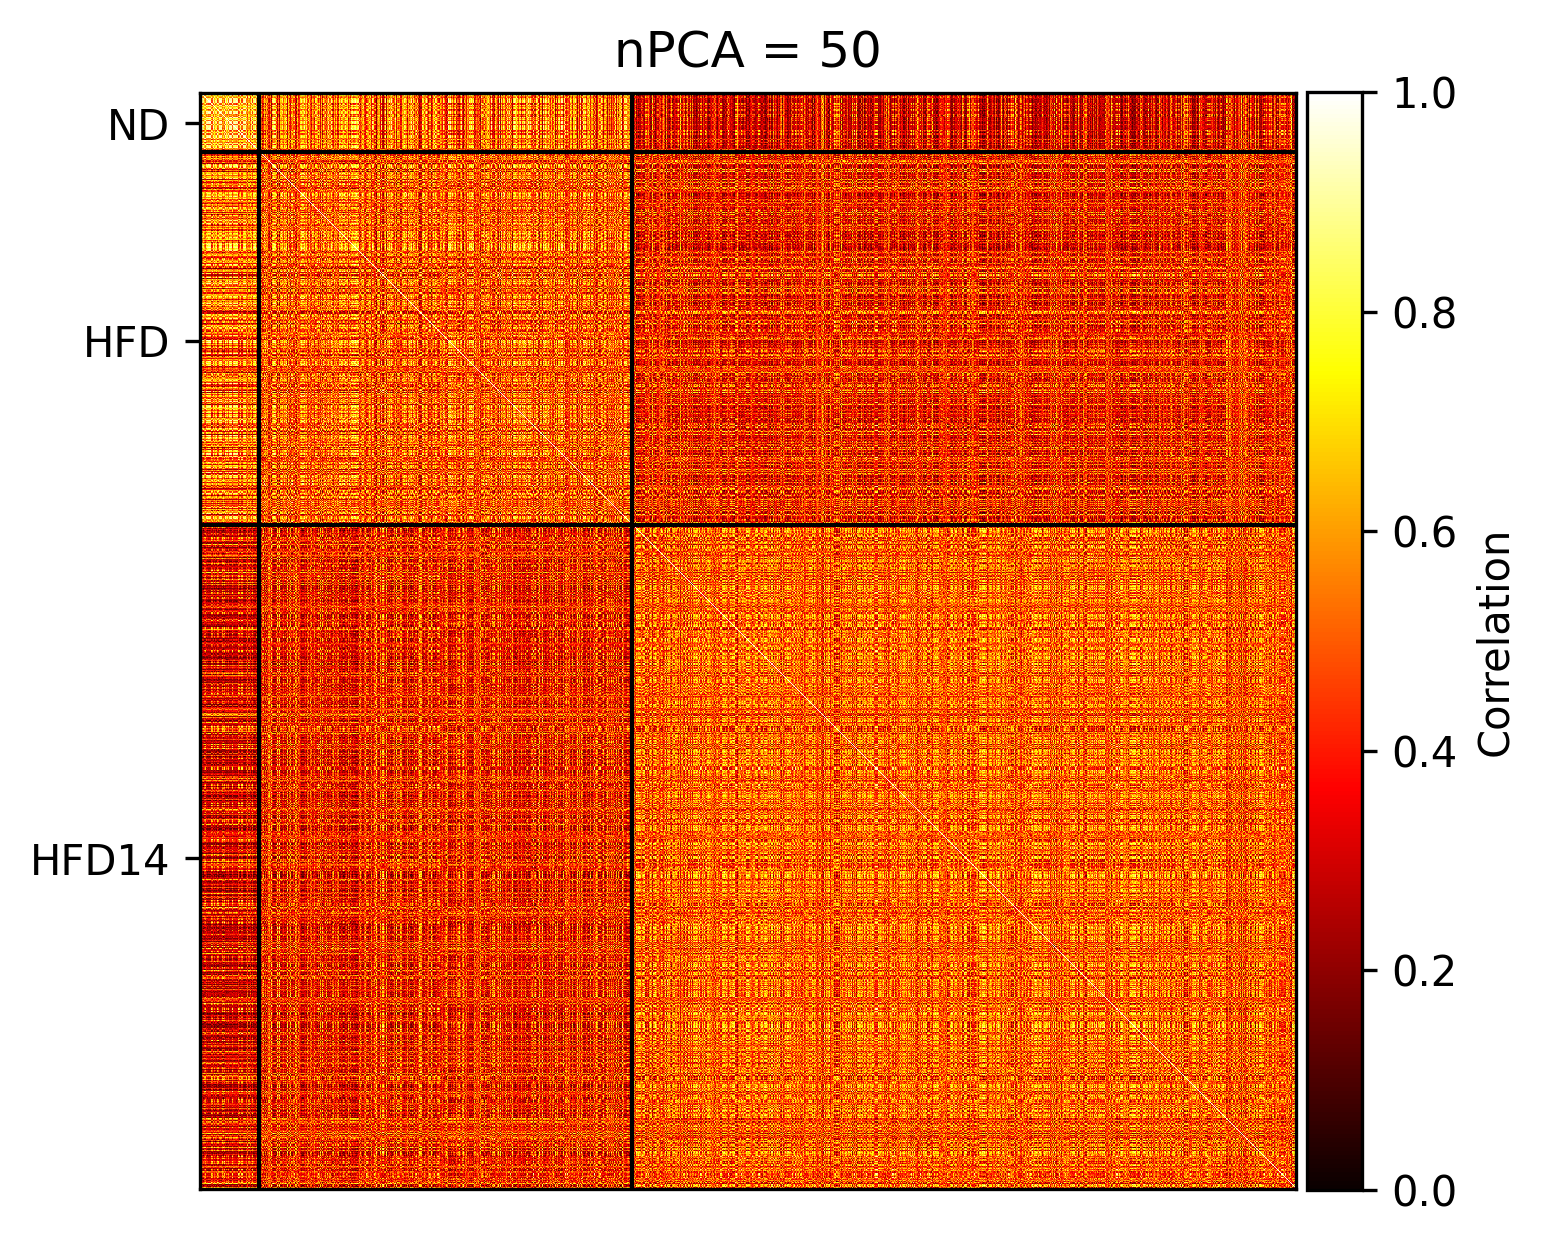

ND Mean 0.6674 (0.1780)
HFD Mean 0.4932 (0.1793)
HFD14 Mean 0.4993 (0.1639)


In [13]:
"""
Construct the distance matrix 
"""
metric='correlation'
r = 50

stdT = 0.2
X = res.fillna(0)
geneStd = X.std(axis=0)
mask = geneStd < stdT
X = X[X.columns[~mask]]
X = X.to_numpy()
print(f"{X.shape=}")

A = getDistanceMatrix(X, r=r, metric=metric)
print(A.shape)

Ahat = A.copy()
Ahat *= 1.0/Ahat.max() 
Ahat = 1 - Ahat # convert distance to similarity

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 5

linc = "k"
lw = 1

plt.matshow(Ahat, cmap='hot')
_ = plt.xticks([])
plt.colorbar(fraction=0.0472, pad=0.01, label='Correlation')

buff = 10
boundaries = [359-buff, 2188+359-buff]
for b in boundaries:
    plt.axvline(x=b, c=linc, lw=lw)
    plt.axhline(y=b, c=linc, lw=lw)

    
locs = [359 / 2, (2188 / 2) + 359, (3884 / 2) + 359 + 2188]
plotLabel = ['ND', 'HFD', 'HFD14']
_ = plt.yticks(locs, plotLabel)     
plt.title(f"nPCA = {r}")

plt.show()

keyCount = 0
for i, j in [(0, 359), (359, 2188+259), (2188+259, 2188+259+3884)]:
    key = plotLabel[keyCount]
    keyCount += 1
    sub = Ahat[i:j, i:j]
    print(f"{key} Mean {sub.mean():.4f} ({sub.std():.4f})")


# for 

# lastType = 'Macrophages'

# labels = []
# ctL = []

# for ct in refs['ctype']:
#     if ct == lastType:
#         labels.append(0)
#     else:
#         ctL.append(lastType)
#         labels.append(1)
#         lastType = ct
        
# inx = np.nonzero(labels)[0]
# print(ctL)
# print(inx)

# locs = []

# lastInx = 0
# for i in inx:
#     plt.axvline(x=i, c=linc, lw=lw)
#     plt.axhline(y=i, c=linc, lw=lw)
    
#     endRange = ((i - lastInx) / 2) + lastInx
#     locs.append(endRange)
#     lastInx = i
    
# endRange = ((A.shape[0] - lastInx) / 2) + lastInx
# locs.append(endRange)

# plotLabel = ["ND Macrophages",
#              "ND Monocytes",
#              "HFD8 Macrophages",
#              "HFD8 Monocytes",
#              "HFD14 Macrophages",
#              "HFD14 Monocytes"]

# _ = plt.yticks(locs, plotLabel) 

In [14]:
# stdT = 0.2
# X = res.fillna(0)
# geneStd = X.std(axis=0)
# mask = geneStd < stdT
# X = X[X.columns[~mask]]
# X = X.to_numpy()
# print(f"{X.shape=}")

# # regress out batch effects
# r = 15
# pca = PCA(n_components=r)
# pcaModel = pca.fit(X)
# Xpca = pca.fit_transform(X)
# print(f"{Xpca.shape=}")

# distances, Abbknn, parameters = bbknn.matrix.bbknn(Xpca, refs['key'].to_list(), neighbors_within_batch=10)      
# Abbknn = Abbknn.todense()
# plt.spy(Abbknn, 
#         marker=".",
#         markersize=0.05)

# buff = 10
# boundaries = [359-buff, 2188+359-buff]
# for b in boundaries:
#     plt.axvline(x=b, c=linc, lw=lw)
#     plt.axhline(y=b, c=linc, lw=lw)

    
# locs = [359 / 2, (2188 / 2) + 359, (3884 / 2) + 359 + 2188]
# plotLabel = ['ND', 'HFD', 'HFD14']
# _ = plt.yticks(locs, plotLabel)     
# plt.title(f"nPCA = {r}")

# plt.show()

# keyCount = 0
# for i, j in [(0, 359), (359, 2188+259), (2188+259, 2188+259+3884)]:
#     key = plotLabel[keyCount]
#     keyCount += 1
#     sub = Ahat[i:j, i:j]
#     print(f"{key} Mean {sub.mean():.4f} ({sub.std():.4f})")


In [15]:
# ?bbknn.matrix.bbknn

In [16]:
# stdT = 0.2
# X = res.fillna(0)
# geneStd = X.std(axis=0)
# mask = geneStd < stdT
# X = X[X.columns[~mask]]
# X = X.to_numpy()
# print(f"{X.shape=}")

# sim = []

# for r in np.linspace(2, 30, 15).astype(int):
#     print(f"working... {r}")
#     A = getDistanceMatrix(X, r=r, metric=metric)

#     Ahat = A.copy()
#     Ahat *= 1.0/Ahat.max() 
#     Ahat = 1 - Ahat # convert distance to similarity
    
#     keyCount = 0
#     for i, j in [(0, 359), (359, 2188+259), (2188+259, 2188+259+3884)]:
#         key = plotLabel[keyCount]
#         keyCount += 1
#         sub = Ahat[i:j, i:j]
        
#         newRow = {
#             'nPCA' : r,
#             'mean' : sub.mean(),
#             'std' : sub.std(),
#             'Key' : key
#         }
#         sim.append(newRow)
        
# sim = pd.DataFrame(sim)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 5, 2

# sns.lineplot(data=sim,
#              x='nPCA',
#              y='mean', 
#              hue='Key')

# plt.ylabel('Mean Similarity')
# plt.xlabel('Number of Components')
# plt.legend(loc='upper right')

0.9810751689493135


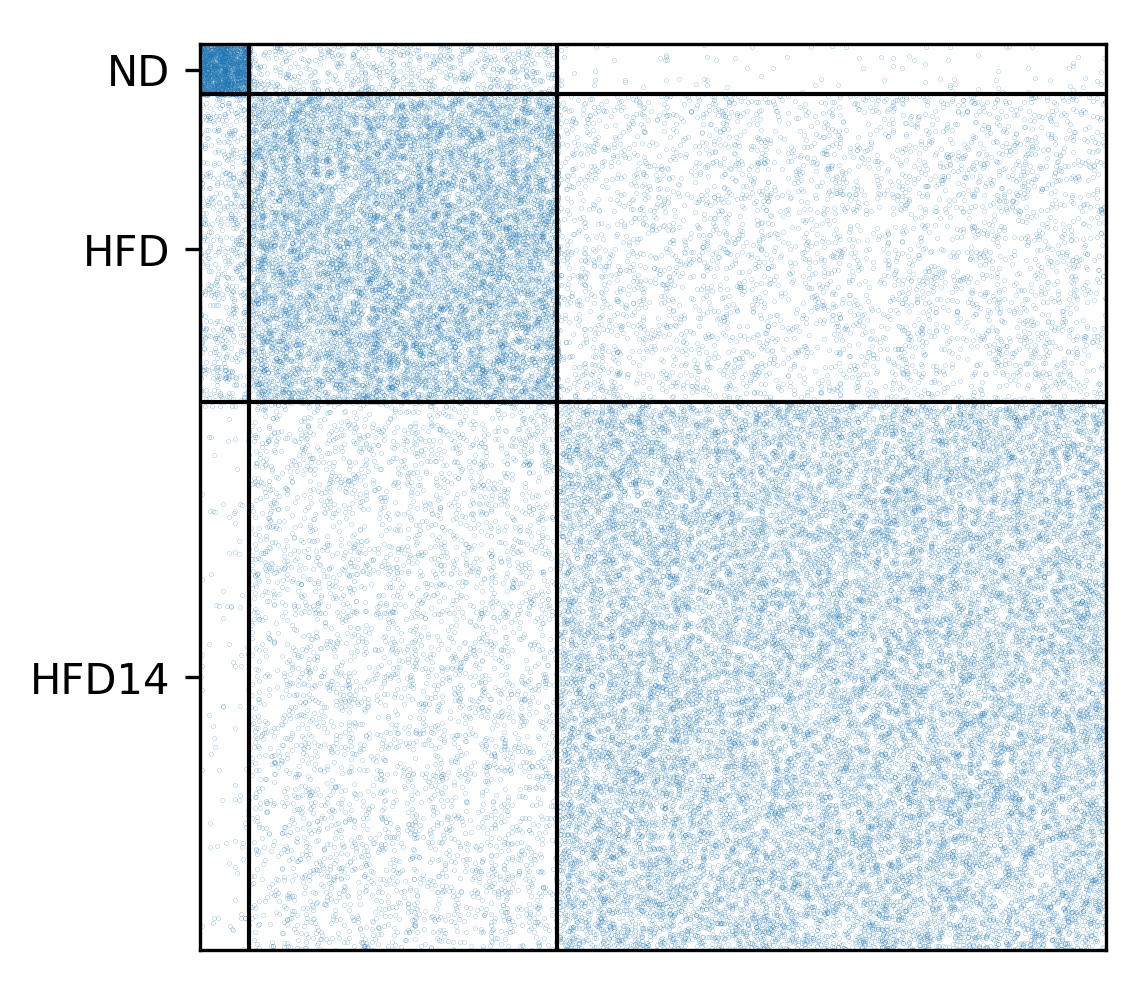

In [17]:
""" Construct the KNN graph"""
stdT = 0.1
X = res.fillna(0)
geneStd = X.std(axis=0)
mask = geneStd < stdT
X = X[X.columns[~mask]]
X = X.to_numpy()

""" get distances """
r = 100
A = getDistanceMatrix(X, r=r, metric=metric)
Ahat = A.copy()
Ahat *= 1.0/Ahat.max() 
Ahat = 1 - Ahat # convert distance to similarity


""" Construct the KNN graph"""
k = 7
knn = kneighbors_graph(Ahat, k)
x, y = np.nonzero(knn.todense())
Aknn = np.zeros(Ahat.shape)

Aknn[x, y] = Ahat[x, y]
print(Aknn.max())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4
plt.spy(Aknn, 
        marker=".",
        markersize=0.1)

_ = plt.xticks([])

buff = 10
boundaries = [359-buff, 2188+359-buff]
for b in boundaries:
    plt.axvline(x=b, c=linc, lw=lw)
    plt.axhline(y=b, c=linc, lw=lw)
    
locs = [359 / 2, (2188 / 2) + 359, (3884 / 2) + 359 + 2188]
plotLabel = ['ND', 'HFD', 'HFD14']
_ = plt.yticks(locs, plotLabel)   

0    2207
4    2039
1     963
2     755
3     467
Name: Spectral, dtype: int64
==== 2 n=963===
HFD14    0.529595
HFD8     0.329180
ND       0.141225
Name: key, dtype: float64

==== 3 n=755===
HFD8     0.687417
ND       0.237086
HFD14    0.075497
Name: key, dtype: float64

==== 5 n=2039===
HFD14    0.692006
HFD8     0.300638
ND       0.007357
Name: key, dtype: float64

==== 4 n=467===
HFD8     0.869379
HFD14    0.077088
ND       0.053533
Name: key, dtype: float64

==== 1 n=2207===
HFD14    0.847304
HFD8     0.150884
ND       0.001812
Name: key, dtype: float64



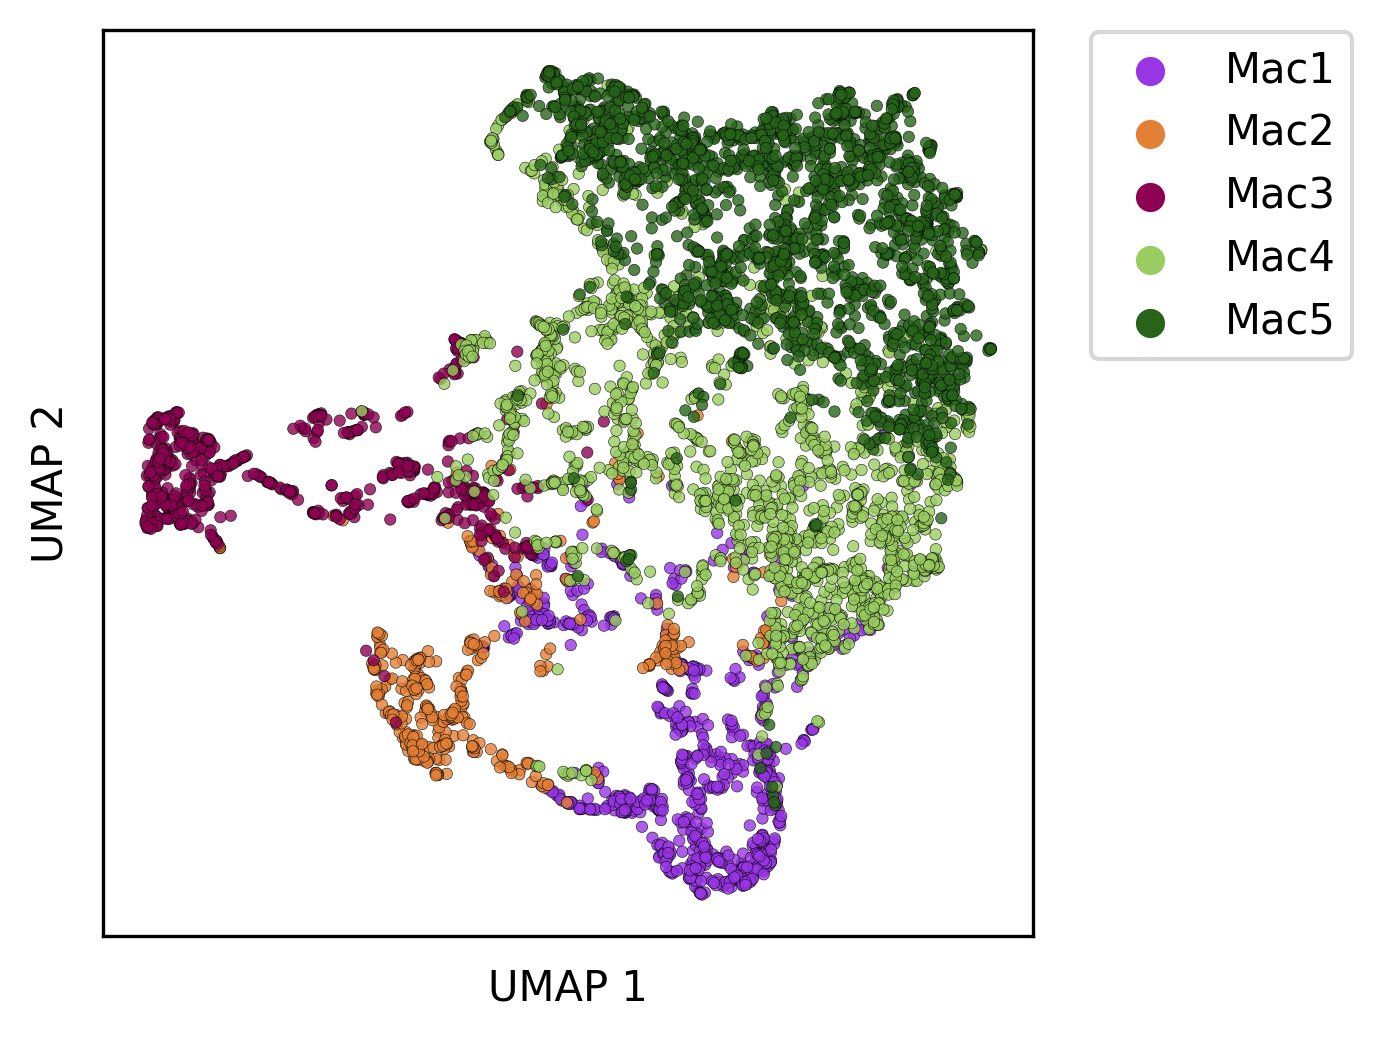

In [18]:
""" recluster the cells using spectral """
k = 5

spect = SpectralClustering(n_clusters=k,
                           affinity='precomputed',
                           assign_labels='discretize',
                           random_state=0).fit(Aknn)

refs['Spectral'] = spect.labels_
print(refs['Spectral'].value_counts())

for cid in refs['Spectral'].unique():
        cluster = refs[refs['Spectral'] == cid]
        print(f"==== {cid+1} n={len(cluster)}===")
        print(cluster['key'].value_counts(normalize=True))
        print()
        
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

pdf = embedding.copy()
pdf['Cluster'] = refs['Spectral'].to_list() 
pdf['Cluster'] = pdf['Cluster'] + 1

subtypes = {
    1 : 'Mac5',
    2 : 'Mac1',
    3 : 'Mac3',
    4 : 'Mac2',
    5 : 'Mac4',
}

pdf['Subtype'] = pdf['Cluster'].map(subtypes)
pdf = pdf.sort_values(by='Subtype')

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

sns.scatterplot(data=pdf,
                x='x',
                y='y',
                marker=".",
                s=30,
                alpha=0.8,
                linewidth=0.15,
                hue='Subtype',
                edgecolor='k',
                palette=colors)

_ = plt.xticks([], [])
_ = plt.yticks([], [])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
    
plt.legend(bbox_to_anchor=(1.04, 1.02))

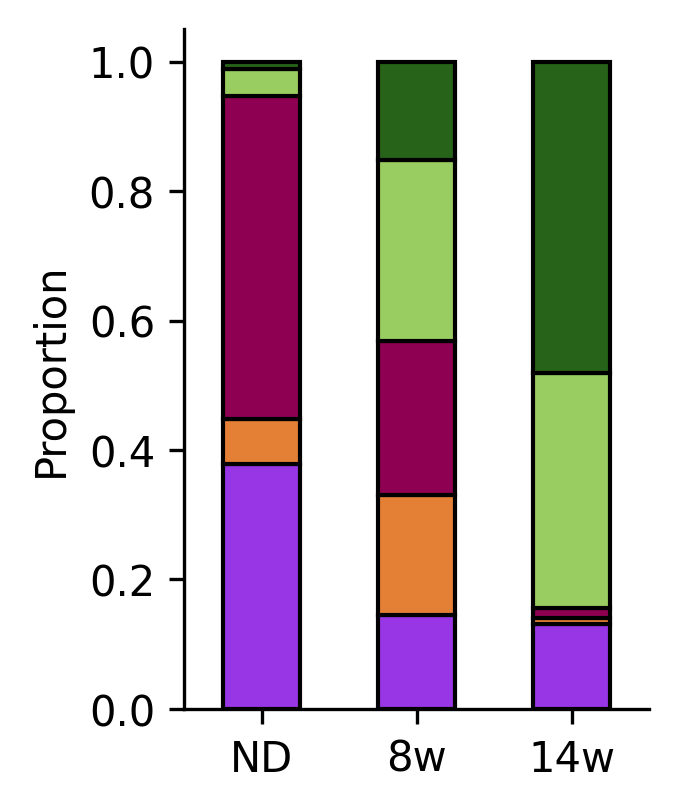

In [19]:
q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)
q = q.sort_values(by='Subtype')

colorMap = dict(zip(q['Subtype'].unique(), colors))
q['color'] = q['Subtype'].map(colorMap)

q = pd.pivot_table(q, 
                   values='CellId', 
                   index=['Subtype'], 
                   columns='key',
                   aggfunc='count')

keys = ['ND', 'HFD8', 'HFD14']
q = q[keys] # column order

for k in keys:
    q[k] = q[k] / q[k].sum()
    
q.columns = ['ND', '8w', '14w'] # rename the columns

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 2, 3

q.T.plot(kind='bar', 
         stacked=True, 
         edgecolor='k',
         legend=False,
         color=colors)
    
# plt.legend(bbox_to_anchor=(1.05, 1.025))
plt.ylabel('Proportion')
_ = plt.xticks(rotation=0)
plt.xlabel("")
sns.despine()
# plt.title("Macrophages")  

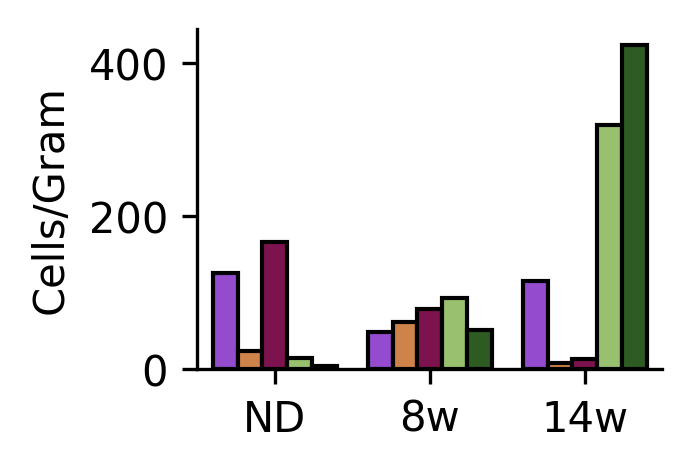

In [32]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 2, 1.5

q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)

q = pd.DataFrame(q[['Subtype', 'key']].value_counts()).reset_index()
q = q.sort_values(by=['key', 'Subtype'])
q.columns = ['subtype', 'time', 'cell count']


keyMap = {
    'ND' : "ND", 
    'HFD8' : "8w",
    'HFD14' : "14w",
}

q['label'] = q['time'].map(keyMap)


# in grams
weights = {
    'ND' : 1.079,
    'HFD8' : 6.573,
    'HFD14' : 4.412,
}

q['weight'] = q['time'].map(weights)
q['cells per gram'] = q['cell count'] / q['weight'] 

q = q.sort_values(by=['time', 'subtype'], ascending=[False, True])


sns.barplot(data=q, 
            x='label', 
            y='cells per gram', 
            edgecolor='k',
            hue='subtype', 
            palette=colors,
            zorder=3)

plt.ylabel('Cells/Gram')
plt.xlabel('')
# plt.grid(True, zorder=0)
plt.legend([],[], frameon=False)
sns.despine()
# legend = plt.gca().legend(bbox_to_anchor=(1.04, 1.02))
# plt.gca().invert_xaxis()

In [21]:
# break

In [22]:
# sf = refs.copy()
# pdf = embedding.copy()

# sf = sf[['CellId', 'key', 'Spectral']]
# sf['clusterId'] = sf['Spectral'] + 1
# sf['subtypeId'] = sf['clusterId'].map(subtypes)
# sf['UMAP X'] = pdf['x']
# sf['UMAP Y'] = pdf['y']


In [23]:
# break

In [24]:
# """Save the clustering results """
# outpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/macrophageSubtypes.csv"

# sf = refs.copy()
# sf = sf[['CellId', 'key', 'Spectral', 'ctype']]
# sf.columns = ['cellId', 'key', 'clusterId', 'cellType']
# sf['clusterId'] = sf['clusterId'] + 1
# sf['subtypeId'] = sf['clusterId'].map(subtypes)
# sf.to_csv(outpath, index=False)
# sf.head()

In [25]:
# sf = refs.copy()
# pdf = embedding.copy()

# sf = sf[['CellId', 'key', 'Spectral']]
# sf['clusterId'] = sf['Spectral'] + 1
# sf['subtypeId'] = sf['clusterId'].map(subtypes)
# sf['UMAP X'] = pdf['x']
# sf['UMAP Y'] = pdf['y']

# cidMap = {
#     "Mac1" : "ATM",
#     "Mac2" : "Activated 1",
#     "Mac3" : "Activated 2",
#     "Mac4" : "LAM 2",
#     "Mac5" : "LAM 1",
# }
# sf['Label'] = sf['subtypeId'].map(cidMap)
# sf = sf[['CellId', 'key', 'clusterId', 'subtypeId', 'UMAP X', 'UMAP Y', 'Label']]
# outpath = "~/temp/macrophageSubtypeClassification.csv"
# sf.to_csv(outpath, index=False)
# sf.head()

==== Cluster 2 TREM2 ====
	precision=0.1364
	accuracy=0.2765
==== Cluster 3 TREM2 ====
	precision=0.0280
	accuracy=0.1378
==== Cluster 5 TREM2 ====
	precision=0.3707
	accuracy=0.4789
==== Cluster 4 TREM2 ====
	precision=0.0300
	accuracy=0.1857
==== Cluster 1 TREM2 ====
	precision=0.4350
	accuracy=0.5542


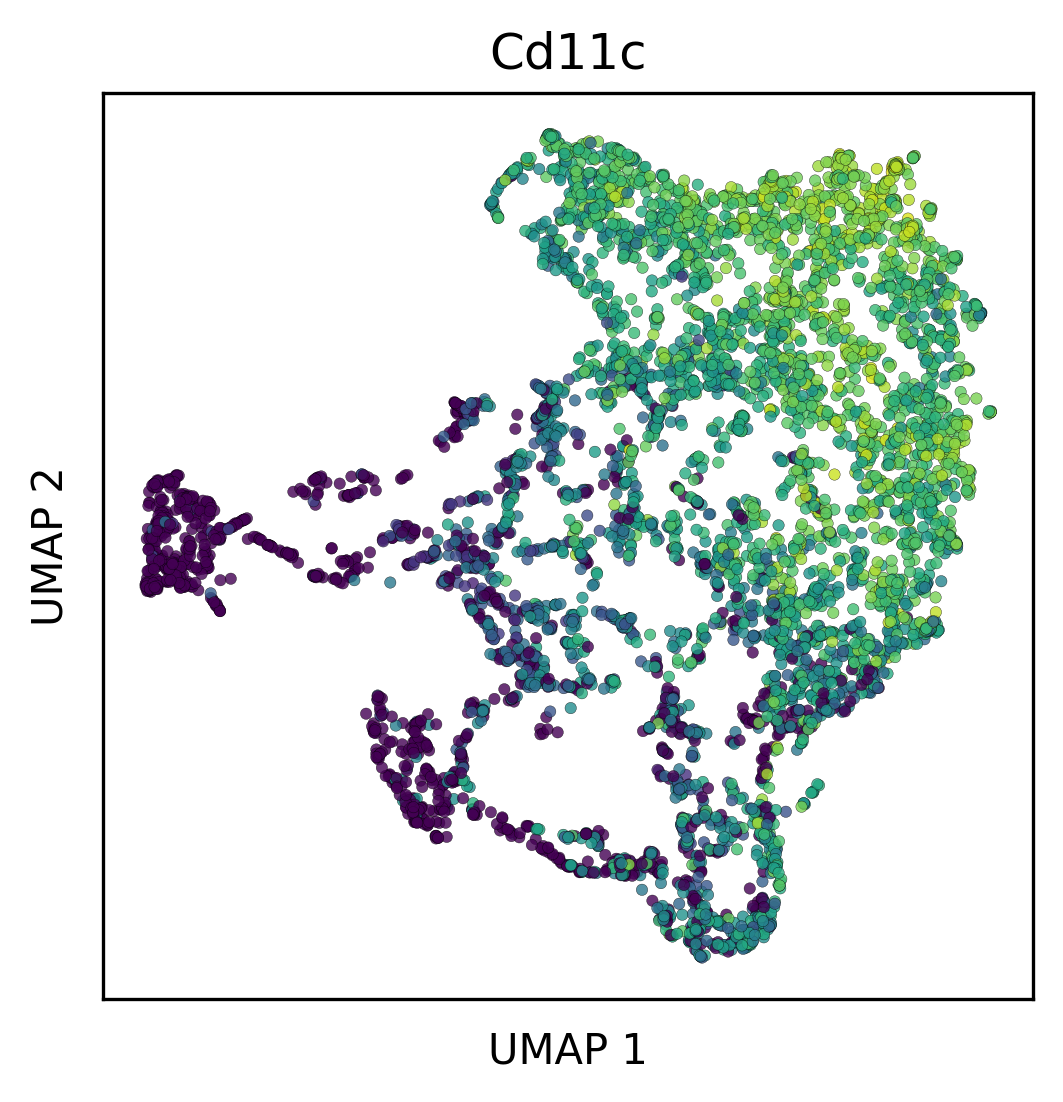

In [34]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4


query = 'Trem2'
query = query.upper()

queryVec = res[query].to_numpy()
queryVec *= (1.0/queryVec.max())

y_pred = np.where(queryVec > 0, 1, 0)

plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=30,
            edgecolor='k',
            lw=0.1,
            cmap='viridis',
            c=queryVec,
            alpha=0.8)

# plt.colorbar(label='Expression')
_ = plt.xticks([], [])
_ = plt.yticks([], [])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title("Cd11c")
# plt.title(str(query).lower().capitalize())

for c in  refs['Spectral'].unique():
    y_true = np.where(refs['Spectral'] == c, 1, 0)
    print(f"==== Cluster {c+1} {query} ====")
    # print(metrics.classification_report(y_true, y_pred))
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    print(f"\t{precision=:.4f}")
    print(f"\t{accuracy=:.4f}")
    

In [27]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
q = refs.copy()
query = 'Mki67'
query = query.upper()

queryVec = res[query].to_numpy()
queryVec *= (1.0/queryVec.max())

y_pred = np.where(queryVec > 0, 1, 0)

y_pred = np.where(queryVec > 0, 1, 0)
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)
q[query] = y_pred


# q = pd.DataFrame(q[['Subtype', 'key', query]].value_counts().reset_index())
# q.columns = ['Subtype', 'Time', query, 'Count']
# q = q.sort_values(by=['Time', 'Subtype'], ascending=[False, True])
# sns.barplot(data=q, 
#             x='Subtype', )

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 3

query = 'Itgax'
query = query.upper()

querVec = res[query].astype(bool)

print(querVec.value_counts(normalize=True))

q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)
newColName = f"{query}+"
q[newColName] = querVec


q = pd.DataFrame(q[['Subtype', newColName]].value_counts(normalize=True).reset_index())
newColName = newColName.lower().capitalize()
q.columns = ['Subtype', newColName, 'Count']
q = q.sort_values(by='Subtype')

sns.barplot(data=q,
            x='Subtype', 
            y='Count', 
            edgecolor='k',
            hue=newColName, 
            palette=['#C1321F', "#429D2A"])


plt.ylabel('Proportion of Macrophages')
plt.xlabel('')


In [ ]:
break

In [ ]:
markers = {
    'Mac1' : ['Mrc1', 'Lyve1'],
    'Mac2' : ['NR4A1', 'Hspa1b'],
    'Mac3' : ['ITGB7', 'NAPSA'],
    'Mac4' : ['H2-EB1', 'CD74'],
    'Mac5' : ['Trem2', 'Cd9'],
}


q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)

colorMap = dict(zip(q['Subtype'].unique(), colors))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 17
cmap = 'viridis'

fig, axs = plt.subplots(5, 3)
axs = axs.ravel()

pdf = embedding.copy()


pltNum = 0
for i, st in enumerate(markers.keys()):
    mask = (q['Subtype'] == st)

    axs[pltNum].scatter(pdf[mask]['x'],
                        pdf[mask]['y'], 
                        c=colors[i], 
                        lw=0.1,
                        zorder=2,
                        ec='k')
    
    axs[pltNum].scatter(pdf[~mask]['x'],
                        pdf[~mask]['y'], 
                        c='lightgrey', 
                        lw=0.1,
                        zorder=1,    
                        ec='None')
    
    axs[pltNum].set_title(st)
    axs[pltNum].set_yticks([])
    axs[pltNum].set_xticks([])
    
    pltNum += 1
    
    q1 = markers[st][0]
    queryVec = res[q1.upper()].to_numpy()
    queryVec *= (1.0/queryVec.max())
    
    axs[pltNum].scatter(embedding['x'],
                        embedding['y'], 
                        edgecolor='k',
                        lw=0.1,
                        cmap=cmap,
                        c=queryVec,
                        alpha=0.8)
    
        
    axs[pltNum].set_title(q1.lower().capitalize())
    axs[pltNum].set_yticks([])
    axs[pltNum].set_xticks([])
    
    pltNum += 1
    
    q1 = markers[st][1]
    queryVec = res[q1.upper()].to_numpy()
    queryVec *= (1.0/queryVec.max())
    
    axs[pltNum].scatter(embedding['x'],
                        embedding['y'], 
                        edgecolor='k',
                        lw=0.1,
                        cmap=cmap,
                        c=queryVec,
                        alpha=0.8)
    
        
    axs[pltNum].set_title(q1.lower().capitalize())
    axs[pltNum].set_yticks([])
    axs[pltNum].set_xticks([])
    
    pltNum += 1
    

plt.tight_layout()

In [ ]:
q.head()

In [ ]:
""" look at DEGS for a query Cells """

q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)
query = 'Mki67'
query = query.upper()
queryVec = res[query].astype(bool)
mask = queryVec == 1

inGroup = res[mask]
outGroup = res[~mask]

labels = q[mask]
print(labels['Subtype'].value_counts())




genes = list(res.columns)

deg = []

for i, g in enumerate(genes):

    scores, pvals = stats.ttest_ind_from_stats(
        mean1=inGroup[g].mean(),
        std1=inGroup[g].std(),
        nobs1=inGroup.shape[0],
        mean2=outGroup[g].mean(),
        std2=outGroup[g].std(),
        nobs2=outGroup.shape[0],
        equal_var=False,  # Welch's
    )
    
    lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
    p = inGroup[g].astype(bool).sum() / mask.sum()
    
    row = {
            'gene' : g,
            'pval' : pvals,
            'logfoldchange' : lfc,
            'meanGroup' : inGroup[g].mean(),
            'meanOther' : outGroup[g].mean(),
            'percExp' : p,
        }
        
    deg.append(row)
        
    
deg = pd.DataFrame(deg)
print(f"{deg.shape=}")
deg.head()

In [ ]:
def printGSR(ef, top=None, columns=['path_name', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

In [ ]:
show = 25
alpha = 0.05
nGene = 1000

db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
# db = 'ontology'

cdf = deg.copy()
cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
cdf = cdf[cdf['pval'] <= alpha]
# print(f"{key} {cdf.shape=}")

cdf['score'] = cdf['logfoldchange'] * cdf['percExp']
cdf = cdf.sort_values(by='score', ascending=False) 
print(cdf[['gene', 'logfoldchange', 'meanGroup', 'meanOther', 'percExp']].head(show), '\n')

query  = deg['gene'].head(nGene).to_list()

pd.set_option('display.max_colwidth', 200)
ef = gget.enrichr(query, database=db)
ef = ef[ef['p_val'] <= alpha].reset_index(drop=True)
printGSR(ef, show)
print()

In [ ]:
break

In [ ]:
res.head()

In [ ]:
markers = [
    'Mrc1', 
    'Lyve1', 
    'Retnla',
    'Mertk',
    'Maf',
    'Cd163', 
    'Timd4',
    'Clec10a',
    'Cd33',
    'Cd80',
    'Cd86',
    'Tgfb2',
    'Cxcl9',
    'Cxcl10',
    'Ccl22',
    'Irf4',
    'Ly6c2',
    'Il6',
    'Apoc1',
    # 'Ackr1',
    'Icam5',
    'Lep',
    "Ocstamp",
    'Vdr',
    'Pparg',
    'Grhl1',
    'Clec4e',
    'Nceh1',
    'Liph',
    'Spp1',
    'Itgax', 
    'Plin2', 
    'Cd9', 
    'Cd63',
    'Cd36',
]



q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)

colorMap = dict(zip(q['Subtype'].unique(), colors))
q['color'] = q['Subtype'].map(colorMap)

gf = []


for st in q['Subtype'].unique():
    mask = (q['Subtype'] == st)
    
    for m in list(set(markers)):
        lfc = np.log(res[mask][m.upper()].mean()) - np.log(res[~mask][m.upper()].mean())
        
        if np.isinf(lfc):
            lfc = 0
        
        row = {
            'Subtype' : st, 
            'Gene' : m.lower().capitalize(),
            'LFC' : lfc,
        }
        gf.append(row)
        
        
gf = pd.DataFrame(gf)
gf = gf.sort_values(by='Subtype')

t = pd.pivot_table(gf, 
                   index='Subtype', 
                   columns='Gene', 
                   values='LFC')

t = t[markers]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3.5, 8

sns.heatmap(data=t.T,
            cmap='PRGn', 
            linewidth=0.2,
            alpha=0.8,
            linecolor='k',
            cbar_kws={'label' : 'LFC', 
                      'shrink' : 0.5})

_ = plt.xticks(rotation=0)
plt.ylabel("")    
plt.xlabel("")

In [ ]:
# [x for x in res.columns if 'LEP' in x]

In [ ]:
break

In [ ]:
res = res.fillna(0)

deg = []

for cid in refs['Spectral'].unique():
    mask = (refs['Spectral'] == cid)
    
    genes = list(res.columns)
    
    inGroup = res[mask]
    outGroup = res[~mask]
    
    for i, g in enumerate(genes):
        
        scores, pvals = stats.ttest_ind_from_stats(
            mean1=inGroup[g].mean(),
            std1=inGroup[g].std(),
            nobs1=inGroup.shape[0],
            mean2=outGroup[g].mean(),
            std2=outGroup[g].std(),
            nobs2=outGroup.shape[0],
            equal_var=False,  # Welch's
        )
        
        lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
        
        p = inGroup[g].astype(bool).sum() / mask.sum()
        
        row = {
            'gene' : g,
            'cluster' : cid+1,
            'subtype' : subtypes[cid+1],
            'pval' : pvals,
            'logfoldchange' : lfc,
            'meanGroup' : inGroup[g].mean(),
            'meanOther' : outGroup[g].mean(),
            'percExp' : p,
        }
        
        deg.append(row)
    
deg = pd.DataFrame(deg)
deg.head()

In [ ]:
n = 20
alpha = 0.05

for st in subtypes.values():
    cdf = deg[deg['subtype'] == st]
    
    cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
    cdf = cdf[cdf['pval'] <= alpha]
    
    cdf['score'] = cdf['logfoldchange'] * cdf['percExp']
    
    cdf = cdf.sort_values(by='score', ascending=False) 
    print(f"==== {st} ====")
    print(cdf[['gene', 'logfoldchange', 'meanGroup', 'meanOther', 'percExp']].head(n), '\n')

In [ ]:
def printGSR(ef, top=None, columns=['path_name', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

In [ ]:
deg['cluster'].min()

In [ ]:
alpha = 0.05
nGene = 100
n = 20
# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

for cid in [2, 4, 3, 5, 1]:
    
    degc = deg[deg['cluster'] == cid]
    subtype = degc['subtype'].unique()[0]

    degc = degc[~degc.isin([np.nan, np.inf, -np.inf]).any(1)]
    degc = degc[degc['pval'] <= alpha]
    degc['score'] = degc['logfoldchange'] * degc['percExp']
    
    degc = degc.sort_values(by='score', ascending=False)    
    genes  = degc['gene'].head(nGene).to_list()
    
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(genes, database=db)
    ef = ef[ef['p_val'] <= alpha].reset_index(drop=True)
    print(f"\n==== {subtype} {len(genes)=} ====")
    printGSR(ef, n)

In [ ]:
break

In [ ]:
# """Leiden clustering """
# sources, targets = Aknn.nonzero()
# weights = Aknn[sources, targets]
# if isinstance(weights, np.matrix):
#     weights = weights.A1
# g = ig.Graph(directed=False)
# g.add_vertices(Aknn.shape[0])  # this adds adjacency.shape[0] vertices
# g.add_edges(list(zip(sources, targets)))
# g.es['weight'] = weights

# weights = np.array(g.es['weight']).astype(np.float64)
# resolution_parameter = 0.2

# partition = la.find_partition(g, 
#                               la.RBConfigurationVertexPartition, 
#                               weights=weights, 
#                               resolution_parameter=resolution_parameter);

# groups = np.array(partition.membership)
# print(np.std(groups))
# print(groups)

# """ recluster the cells """


# pdf = embedding.copy()
# pdf['Cluster'] = groups
# pdf['Cluster'] = pdf['Cluster'] + 1

# sns.scatterplot(data=pdf,
#                 x='x',
#                 y='y',
#                 marker=".",
#                 s=30,
#                 alpha=0.8,
#                 linewidth=0.1,
#                 hue='Cluster',
#                 edgecolor='k',
#                 palette='Spectral')

# _ = plt.xticks([], [])
# _ = plt.yticks([], [])
# plt.ylabel("UMAP 2")
# plt.xlabel("UMAP 1")

# plt.legend(bbox_to_anchor=(1.04, 1.02))

In [ ]:
break

In [ ]:
# Ahat = A.copy()
# Ahat *= 1.0/Ahat.max() 

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 5, 5


# plt.matshow(Ahat, cmap='hot')
# _ = plt.xticks([])
# _ = plt.yticks([])
# plt.colorbar(fraction=0.0472, pad=0.01, label='Distance')
# plt.xlabel("Cells")
# plt.ylabel("Cells")

In [ ]:
# def getA(X, r, metric='euclidean'):
#     """A function to get the distance matrix A.
#     Expected a centered data matrix"""
    
#     Xc = X.fillna(0).apply(lambda x: x-x.mean())
#     Xc = Xc.to_numpy()
    
#     # SVD
#     u, s, v = np.linalg.svd(Xc)
    
#     # construct P
#     P = u[:, 0:r]
    
#     # build distance matrix
#     return squareform(pdist(P, metric=metric))
    
    
# A = getA(res, r=15)
# plt.matshow(A)